# Projeto de Eletromagnetismo e Ondulatória
Carol Magario, Isabella Leão, Laura Tovo, Lucas Sato e Victoria Souza

Turma 4B

# Objetivo do projeto
Neste projeto, adaptando o modelo de um transformador a um circuito WPT, o objetivo foi tentar modelar um acoplamento de bobinas ressonantes que não estivessem próximas, tendo somente o ar entre elas. Dessa maneira, para que isso fosse possível, na primeira etapa do projeto foram feitos modelos e simulações numéricas para que pudessem prever o comportamento do sistema, simulado por python, identificando a frequência ótima (máxima) de transmissão para cada condição de carga e coeficiente de acoplamento, além de identificar o fator de acoplamento ótimo dada uma frequência de operação. Já na segunda parte do projeto, foi realizado a montagem do circuito, medições e validação do modelo teórico.

# Etapa I: Simulações numéricas 
## Circuito usado
<img src="circuito porém bonito.png" height="426">  

## Importando bibliotecas necessárias
Para que seja possível realizar os cálculos numéricos, algumas bibliotecas do python foram utilizadas:

In [1]:
from cmath import *
from numpy import linalg
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Classe de Transformador
Para essa primeira parte do código, faz-se necessário gerar um objeto do tipo transformador para calcular a indutância mútua, as frêquencias de ressonancia e o fator de qualidade com as propriedades calculadas. 

In [2]:
class Transformador():
    R1, R2 = 0, 0
    L1, L2 = 0, 0
    C1, C2 = 0, 0
    k=1

    def M(self): #indutância mútua
        return self.k*sqrt(self.L1*self.L2)
    def Ressonancia(self): #ressonância do primário e secundário
        return [1/(2*pi*sqrt(self.L1*self.C1)), 1/(2*pi*sqrt(self.L2*self.C2))] 
    def FatoresDeQualidade(self):
        return [sqrt(self.L1/self.C1)/self.R1, sqrt(self.L2/self.C2)/self.R2]

## Função que calcula as correntes de um transformador
Para saber as correntes $i_1$ e $i_2$ com capacitor $C_1$ em série com o primário e $C_2$ em paralelo no secundário.

In [3]:
def CalcularTransformadorC2Paralelo(Trafo, V1, Rcarga, freq):
    w = 2*pi*freq #velocidade angular
    
    #impedâncias
    R1 = Trafo.R1
    R2 = Trafo.R2
    XL1 = 1j*w*Trafo.L1
    XL2 = 1j*w*Trafo.L2
    XM = 1j*w*Trafo.k*sqrt(Trafo.L1*Trafo.L2)      
    XC1 = 1/(1j*w*Trafo.C1)
    XC2 = 1/(1j*w*Trafo.C2)   
    
    Zparalelo = 1/(1/XC2+1/Rcarga) #impedância do C2 e Rcarga em paralelo no secundário
    
    Z = np.array([[R1+XL1+XC1, -XM], [XM, -XL2-R2-Zparalelo]]) #matriz de impedância do primário e do secundário
    
    #adaptação: no circuito é onda quadrada, então a amplitude precisa ser menor (amplitude da fundamental) 
    V = np.array([V1, 0]) #matriz de tensão
    
    i = np.dot(linalg.inv(Z), V) #matriz de corrente com a lei de Ohm
    
    return i[0], i[1] #lista com correntes i1 e i2

## Criando o transformador usado para testes e validação do modelo
Aqui nós criamos um transformador com as propriedades do transformador usado para testes e validação do modelo. O transformador usado possui as seguintes propriedades:

In [4]:
Trafo1 = Transformador()
Trafo1.R1 = 0.5
Trafo1.R2 = 0.5
Trafo1.L1 = 300e-6
Trafo1.L2 = 300e-6
Trafo1.C1 = 0.1e-6
Trafo1.C2 = 0.1e-6
Trafo1.k = 0.3

f = 30e3 #frequência ideal encontrada e arredondada
Uf = 9 #tensão máxima da fonte [V]
V1 = 2*Uf/pi #tensão do primário (Lei de Fourrier) [V]
w = 2*pi*f


## Relação $f_R$ x $V_{out}$
### Gráfico $|V_2|$ x $f_R$
A relação entre a frequência de ressonância e a tensão de saída é dada por:	

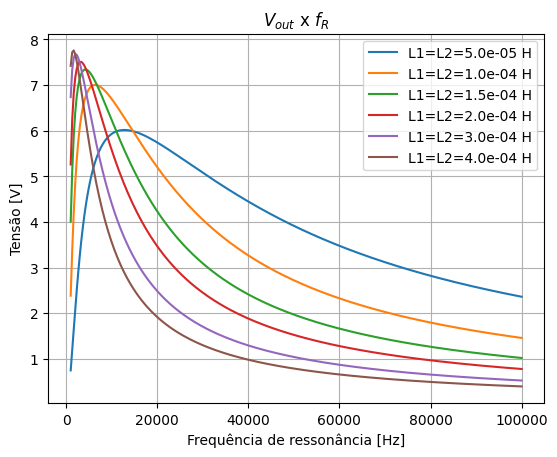

In [44]:
Rc = 10 #carga em ohm

lisIndutancias = [50e-6, 100e-6, 150e-6, 200e-6, 300e-6, 400e-6] #indutâncias dos capacitores disponíveis em H
lisFreq = np.linspace(1e3, 100e3, 300) #frequências em Hz

for L in lisIndutancias:
    Trafo1.L1 = L
    Trafo1.L2 = L
    lisVout = []

    for freq in lisFreq:
        w = 2*pi*freq #velocidade angular
        
        #cálculo das capacitâncias a partir das indutâncias
        Trafo1.C1 = 1/(Trafo1.L1*w**2)
        Trafo1.C2 = 1/(Trafo1.L2*w**2)
        
        #cálculo da resistência considerando o efeito pelicular
        Trafo1.R1 = 0.9+0.9*10*freq/100e3
        Trafo1.R2 = 0.9+0.9*10*freq/100e3
        
        i1, i2 = CalcularTransformadorC2Paralelo(Trafo1, Uf, Rc, freq) #correntes no primário e secundário
        
        XC2 = 1/(1j*w*Trafo1.C2) 
        Zparalelo = 1/(1/Rc+1/XC2)
        Vout = Zparalelo*i2
        lisVout.append(abs(Vout)) #tensão de saída V2

    plt.plot(lisFreq, lisVout, label="L1=L2=%.1e H" %L)
plt.title("$V_{out}$ x $f_R$")
plt.xlabel("Frequência de ressonância [Hz]")
plt.ylabel("Tensão [V]")
plt.legend()
plt.grid(True)
plt.show()

## Encontrando $i_{1, max}$ e $i_{2, max}$ para $f_R$

In [6]:
#reset dos dados para validação para achar a frequência para a corrente máxima
Trafo1.R1 = 0.5
Trafo1.R2 = 0.5
Trafo1.L1 = 300e-6
Trafo1.L2 = 300e-6
Trafo1.C1 = 0.1e-6
Trafo1.C2 = 0.1e-6
Trafo1.k = 0.3

#listas e valores para armazenar os dados
I1, I2 = [], []
max_i1, max_i2 = 0, 0

listaF = np.arange(1e3, 100e3, 10) #frequências em Hz com menor intervalo para cálculos
listaFplot = np.arange(1, 100, 10) #frequências em kHz com menor intervalo para plotar gráficos

## Correntes máximas
### Gráfico do módulo das correntes x $f_R$

Correntes máximas para k=0.1: i1 = 0.89A em f = 29190.0Hz, i2 = 0.09A em f = 29220.0Hz
Correntes máximas para k=0.2: i1 = 0.85A em f = 29600.0Hz, i2 = 0.16A em f = 29630.0Hz
Correntes máximas para k=0.3: i1 = 0.78A em f = 30330.0Hz, i2 = 0.23A em f = 30370.0Hz
Correntes máximas para k=0.4: i1 = 0.7A em f = 31460.0Hz, i2 = 0.27A em f = 31520.0Hz
Correntes máximas para k=0.5: i1 = 0.62A em f = 33160.0Hz, i2 = 0.3A em f = 33240.0Hz
Correntes máximas para k=0.6: i1 = 0.54A em f = 35750.0Hz, i2 = 0.32A em f = 35860.0Hz
Correntes máximas para k=0.7: i1 = 0.47A em f = 39930.0Hz, i2 = 0.33A em f = 40100.0Hz
Correntes máximas para k=0.8: i1 = 0.4A em f = 47750.0Hz, i2 = 0.33A em f = 48030.0Hz
Correntes máximas para k=0.9: i1 = 0.36A em f = 69380.0Hz, i2 = 0.33A em f = 69740.0Hz


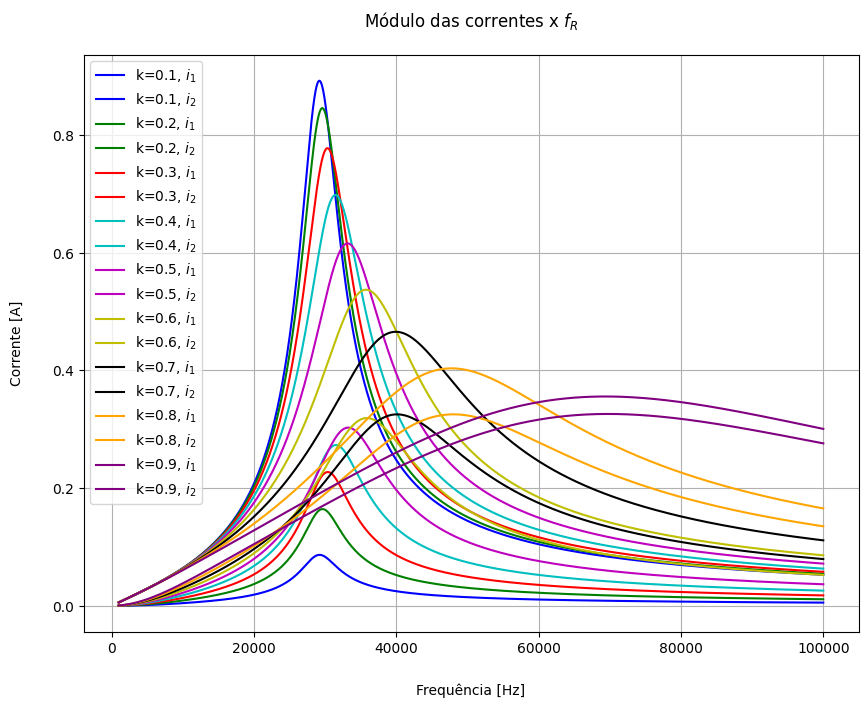

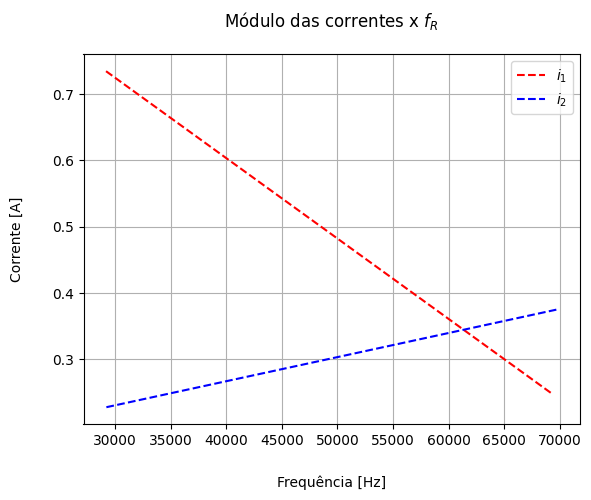

In [39]:
#Para criar linhas de tendências no gráfico
peak_freqs_i1, peak_freqs_i2 = [], []
peak_i1, peak_i2 = [], []
listaK=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'navy', 'teal']
plt.figure(figsize=(10,7.5))

for k, color in zip(listaK, colors):
    Trafo1.k=k
    I1, I2 = [], []
    max_i1, max_i2 = 0, 0
    
    for freq in listaF: #busca pelas correntes máximas nos dois transformadores
        i1, i2 = CalcularTransformadorC2Paralelo(Trafo1, Uf, Rc, freq)
        I1.append(abs(i1))
        I2.append(abs(i2))

        if(abs(i1) > max_i1):
            max_i1 = abs(i1) #corrente máxima no primário
            freq_max_i1 = freq #frequência onde ocorre
        
        if(abs(i2) > max_i2):
            max_i2 = abs(i2) #corrente máxima no secundário
            freq_max_i2 = freq #frequência onde ocorre

    peak_freqs_i1.append(freq_max_i1)
    peak_freqs_i2.append(freq_max_i2)
    peak_i1.append(max_i1)
    peak_i2.append(max_i2)

    print("Correntes máximas para k={}: i1 = {}A em f = {}Hz, i2 = {}A em f = {}Hz".format(k,max_i1.round(2), freq_max_i1, max_i2.round(2), freq_max_i2))
    plt.plot(listaF, I1, label = "k={}, $i_1$".format(k), color=color)
    plt.plot(listaF, I2, label = "k={}, $i_2$".format(k), color=color)  

plt.title("Módulo das correntes x $f_R$", pad=20)
plt.xlabel("Frequência [Hz]", labelpad = 20)
plt.ylabel("Corrente [A]", labelpad = 20)
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Fit a line to the peak points
z1 = np.polyfit(peak_freqs_i1, peak_i1, 1)
p1 = np.poly1d(z1)
plt.plot(peak_freqs_i1, p1(peak_freqs_i1), "r--", label = "$i_1$")

z2 = np.polyfit(peak_freqs_i2, peak_i2, 1)
p2 = np.poly1d(z2)
plt.plot(peak_freqs_i2, p2(peak_freqs_i2), "b--", label = "$i_2$")

plt.title("Módulo das correntes x $f_R$", pad=20)
plt.xlabel("Frequência [Hz]", labelpad = 20)
plt.ylabel("Corrente [A]", labelpad = 20)
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Testando o modelo
Usando $R_{carga}$ = 10 $\Omega$, k = 0.5 e $f$ = 30 kHz, conforme encontrado acima.

In [32]:
Rcarga = 10
Trafo1.k = 0.5
i1, i2 = CalcularTransformadorC2Paralelo(Trafo1, Uf, Rcarga, 30e3)

print("i1:", abs(i1).round(2), "A\ni2:", abs(i2).round(2), "A")

i1: 0.52 A
i2: 0.25 A


## Determinando parâmetros máximos
Calculando $Pot_{out, max}$ e $f_{R, max}$ no transformador primário e $f_{max}$ no transformador secundário.

In [33]:
LisPentrada, LisPsaida, LisEficiencia, LisVout = [], [], [], []

for freq in listaF:
    Trafo1.R1 = 0.9+0.9*10*freq/100e3 #efeito pelicular
    Trafo1.R2 = 0.9+0.9*10*freq/100e3 #efeito pelicular
    i1, i2 = CalcularTransformadorC2Paralelo(Trafo1, V1, Rcarga, freq)
    
    Sin = (V1/sqrt(2))*(i1.conjugate()/sqrt(2)) #potência eficaz de entrada
    
    #corrente no Rc
    w=2*pi*freq 
    XC2=1/(1j*w*Trafo1.C2) 
    Zparalelo=1/(1/Rcarga+1/XC2)
    Vout=Zparalelo*i2
    icarga=Vout/Rcarga
    
    Sout=(Vout/sqrt(2))*(icarga.conjugate()/sqrt(2)) #potência eficaz de saída
    
    #armazenando os valores calculados para encontrar o mais alto
    LisPentrada.append(Sin.real)
    LisPsaida.append(Sout.real)
    LisVout.append(abs(Vout))
    LisEficiencia.append(Sout.real/Sin.real)

indice, psaida = 0, 0
for i in range(0, len(listaF)):
    if LisPsaida[i] > psaida:
        psaida = LisPsaida[i] #potência eficaz de saída mais alta
        indice = i #frequência onde ocorre

print(f"Potência de saída máxima: {max(LisPsaida).round(2)}W")
print(f"Frequência de ressonância máxima (primário): {abs(Trafo1.Ressonancia()[0])}Hz")
print(f"Frequência máxima (secundário): {listaF[indice]}Hz")

Potência de saída máxima: 0.74W
Frequência de ressonância máxima (primário): 29057.584156627367Hz
Frequência máxima (secundário): 33360.0Hz


## Gráficos $\dot{W}$ x $f$ e $Ef$ x $f$

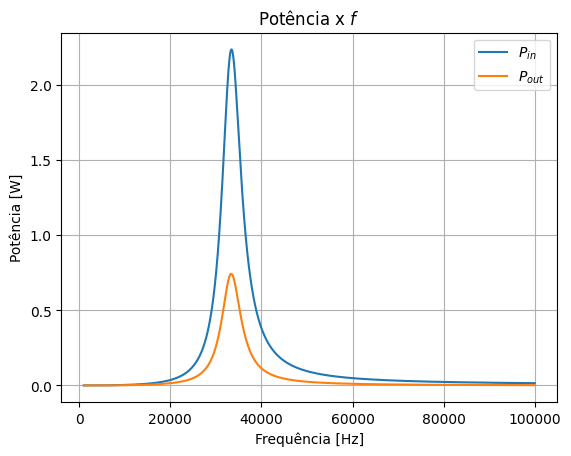

In [43]:
plt.plot(listaF, LisPentrada, label = "$P_{in}$")
plt.plot(listaF, LisPsaida, label = "$P_{out}$")
plt.title("Potência x $f$")
plt.ylabel("Potência [W]")
plt.xlabel("Frequência [Hz]")
plt.legend()
plt.grid(True)
plt.show()

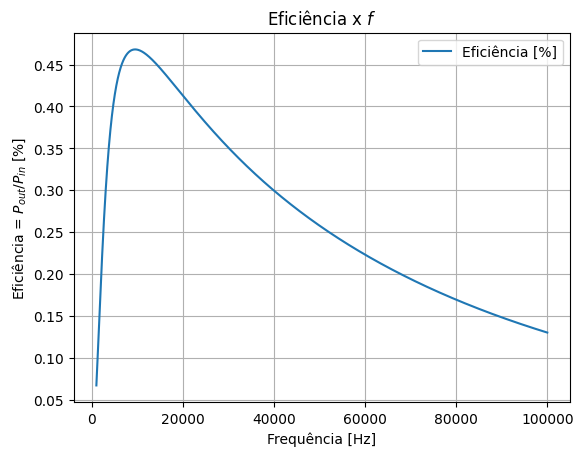

In [41]:
plt.plot(listaF, LisEficiencia, label = "Eficiência [%]")
plt.title("Eficiência x $f$")
plt.ylabel("Eficiência = $P_{out}/P_{in}$ [%]")
plt.xlabel("Frequência [Hz]")
plt.legend()
plt.grid(True)
plt.show()

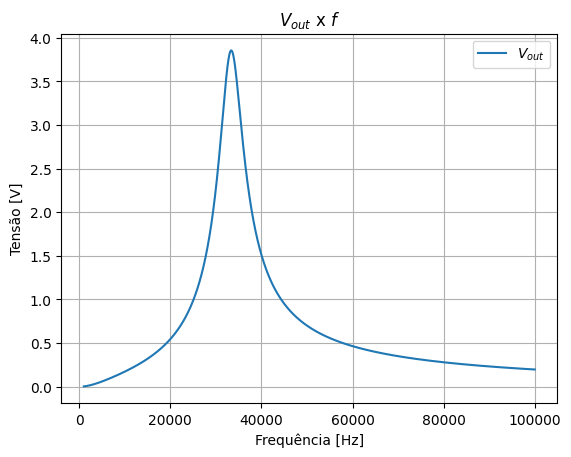

In [40]:
plt.plot(listaF, LisVout, label = "$V_{out}$")
plt.title("$V_{out}$ x $f$")
plt.ylabel("Tensão [V]")
plt.xlabel("Frequência [Hz]")
plt.legend()
plt.grid(True)
plt.show()

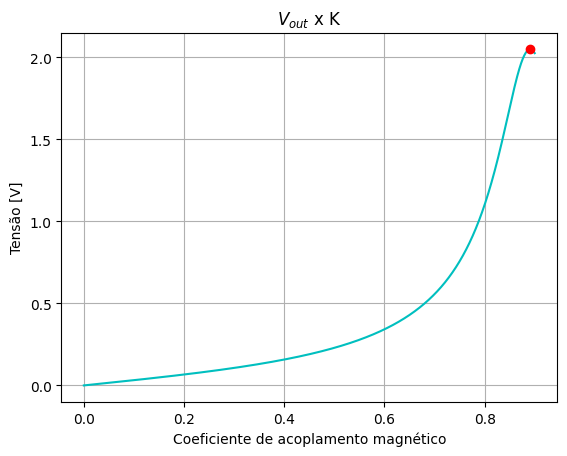

2.0489374671753224
0.8907478149562992


In [48]:
%matplotlib inline
lisk = np.linspace(0, 0.9, 50000) #valores de k possíveis, com intervalos menores

lisVout = []

for k in lisk:
    Trafo2.k = k
    i1, i2 = CalcularTransformadorC2Paralelo(Trafo2, V1, Rcarga, f)

    Sin = V1*i1.conjugate()/2 #potência eficaz na entrada

    #tensão na saída
    XC2 = 1/(1j*w*Trafo2.C2) 
    Zparalelo = 1/(1/Rcarga+1/XC2)
    Vout = Zparalelo*i2
    
    lisVout.append(abs(Vout))
    
VoutMaximo = max(lisVout) #acha a tensão máxima
K_onde_maximo = lisk[lisVout.index(VoutMaximo)] #e o k onde acontece
    
plt.plot(lisk, lisVout,'c')
plt.plot(K_onde_maximo,VoutMaximo,'ro')
plt.title("$V_{out}$ x K")
plt.grid(True)
plt.xlabel("Coeficiente de acoplamento magnético")
plt.ylabel("Tensão [V]")
plt.show()

print(max(lisVout))
print(K_onde_maximo)

## Gráficos 3D

In [11]:
#dados para plotar o gráfico em 3D
Freq=np.linspace(20e3,40e3,2000)
K=np.linspace(0,0.9,2000)

Potencia = []
Eficiencia=[]

for i_freq in range(len(Freq)):
    lisPout=[]
    lisEfic=[]
    for i_k in range(len(K)):        
        Trafo1.k=K[i_k]
        i1, i2 = CalcularTransformadorC2Paralelo(Trafo1, V1, Rcarga, Freq[i_freq])
        Sin=V1*i1.conjugate()
        w=2*pi*Freq[i_freq]
        XC2=1/(1j*w*Trafo1.C2) 
        Zparalelo=1/(1/Rcarga+1/XC2)
        Vout=Zparalelo*i2
        icarga=Vout/Rcarga
        Sout=Vout*icarga.conjugate()
        lisPout.append(Sout.real)
        lisEfic.append(Sout.real/Sin.real)
        
    Potencia.append(lisPout)
    Eficiencia.append(lisEfic)
print("Listas prontas!")

Listas prontas!


# Código para plotar o gráfico $\dot{W}$ x $f$ x $k$

In [12]:
%matplotlib qt5
fig = plt.figure()
axes1 = fig.add_subplot(projection = '3d')

X,Y=np.meshgrid(K,Freq) 
Z=np.array(Potencia)

# superfície
surf = axes1.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# eixos x, y e z
axes1.set_zlim(-1.01, 1.01)
axes1.zaxis.set_major_locator(LinearLocator(10))
axes1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
axes1.xaxis.set_major_formatter(FormatStrFormatter('%.02f'))
axes1.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

# mapeamento de cores
fig.colorbar(surf, shrink=0.3, aspect=5)

# legendas
axes1.set_xlabel("k")
axes1.set_ylabel("$f$ (Hz)")
axes1.set_zlabel("$\dot{W}$ (W)")

plt.show()

# Código para plotar o gráfico $Ef$ x $f$ x $k$

In [45]:
%matplotlib qt5
fig = plt.figure()
axes1 = fig.add_subplot(projection = '3d')       
X,Y=np.meshgrid(K,Freq) 
Z=np.array(Eficiencia)

# superfície
surf = axes1.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# eixo z
axes1.set_zlim(-1.01, 1.01)
axes1.zaxis.set_major_locator(LinearLocator(10))
axes1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


# mapeamento de cores
fig.colorbar(surf, shrink=0.3, aspect=5)

#legendas
axes1.set_xlabel("k")
axes1.set_ylabel("$f$ (Hz)")
axes1.set_zlabel("$Ef$")

plt.show()

# Etapa II: Montagem do circuito, medições e validação do modelo

## Montagem do circuito
Após isso, foi feita a montagem do circuito que fornecerá energia ao sistema. As imagens a seguir representam o resultado da montagem:

<img src="circuitofisico.jpg">

## Montagem das bobinas:
Usando o [Physika](https://physika.info/site/aplicativos/javascript/inkalc.htm) para estimar os valores de indutância das bobinas, foi encontrada a autoindutância das bobinas. Seguindo o número de voltas indicado pelo site, foi possível atingir uma autoindutância de cerca de $390 \mu H$ para ambas as bobinas.

<img src="sobobinas.jpg">

## Sinal lido no osciloscópio:
Com o circuito montado foi possível medir o sinal de saída no osciloscópio, de aproximadamente $$ a uma frequência de ressonância de $30kHz$.

<img src="sinal.jpg" height="300">

## Criando o transformador usado experimentalmente
Parâmetros medidos no laboratório para o transformador usado experimentalmente:
* $f$ = 30 $kHz$;
* fio 16AWG;
* diâmetro = $23.2 cm$
* número de voltas: 27

<img src="physika.png" height="300">

In [14]:
Trafo2 = Transformador()
Trafo2.R1 = 1.756 #+ # resistência equivalente da bobina e dos fios usados
Trafo2.R2 = 1.620 #+ # resistência equivalente da bobina e dos fios usados
Trafo2.L1 = 388.5e-6 # indutancia L1 medida pelo LCR
Trafo2.L2 = 389.2e-6 # indutancia L2 medida pelo LCR
Trafo2.C1 = 0.47e-6 # capacitor usado
Trafo2.C2 = 0.47e-6 # capacitor usado

In [15]:
LisPentrada, LisPsaida, LisEficiencia, LisVout = [], [], [], []
Rcarga = 330 #reset de Rc usado para o experimento

for freq in listaF:
    i1, i2 = CalcularTransformadorC2Paralelo(Trafo2, V1, Rcarga, freq)
    
    Sin = (V1/sqrt(2))*(i1.conjugate()/sqrt(2)) #potência eficaz de entrada
    
    #calculo da corrente no Rc
    w=2*pi*freq
    XC2=1/(1j*w*Trafo2.C2) 
    Zparalelo=1/(1/Rcarga+1/XC2)
    Vout=Zparalelo*i2
    icarga=Vout/Rcarga
    
    Sout=(Vout/sqrt(2))*(icarga.conjugate()/sqrt(2)) #potência eficaz de saída
    
    #armazenando os valores calculados para encontrar o mais alto
    LisPentrada.append(Sin.real)
    LisPsaida.append(Sout.real)
    LisVout.append(abs(Vout))
    LisEficiencia.append(Sout.real/Sin.real)

indice, psaida = 0, 0
for i in range(0, len(listaF)):
    if LisPsaida[i] > psaida:
        psaida = LisPsaida[i] #potência eficaz de saída mais alta
        indice = i #frequência onde ocorre

print(f"Potência de saída máxima: {max(LisPsaida).round(2)}W")
print(f"Frequência de ressonância máxima (primário): {abs(Trafo2.Ressonancia()[0])}Hz")
print(f"Frequência máxima (secundário): {listaF[indice]}Hz")

Potência de saída máxima: 1.17W
Frequência de ressonância máxima (primário): 11778.112307128977Hz
Frequência máxima (secundário): 8360.0Hz


## Gráfico Eficiência x Distância com os valores medidos

Potência de saída máxima: 0W


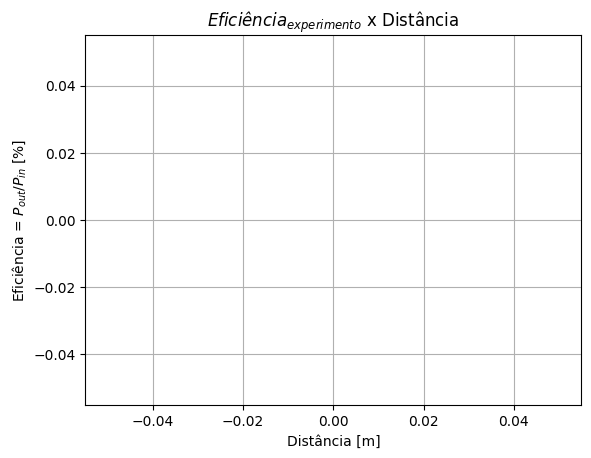

In [16]:
%matplotlib inline
Distancias = [0.447,0.403,0.357,0.297,0.245,0.21,0.176,0.134,0.104,0.094,0.066,0.052]
TensoesMedidas = [0.6,0.76,1.05,1.65,2.53,3.26,4.46,7.16,10.5,14.1,20.9,25.3]
LisEficiencia = []
Smax = 0

XL1 = 1j*w*Trafo2.L1
XC1 = 1/(1j*w*Trafo2.C1)
for y in range(0,len(TensoesMedidas)):
    Sin = ((V1**2)/(Trafo2.R1+XL1+XC1))/2
    Vout = TensoesMedidas[y]
    icarga = Vout/Rcarga
    Sout = (Vout*icarga.conjugate())/2 #potência eficaz de saída
    LisEficiencia.append(Sout.real/Sin.real) #eficiência eficaz
    
    if (Sout>Smax):
        Smax = Sout

print(f"Potência de saída máxima: {round(Smax,2)}W")     
plt.title("$Eficiência_{experimento}$ x Distância")
plt.plot(Distancias, LisEficiencia, "ro-")
plt.ylabel("Eficiência = $P_{out}/P_{in}$ [%]")
plt.xlabel("Distância [m]")
plt.grid(True)
plt.show()

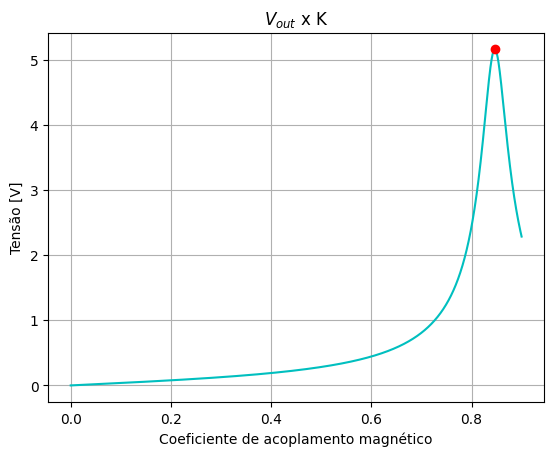

5.15849123795149
0.846484929698594


In [17]:
lisk = np.linspace(0, 0.9, 50000) #valores de k possíveis, com intervalos menores

lisVout = []

for k in lisk:
    Trafo2.k = k
    i1, i2 = CalcularTransformadorC2Paralelo(Trafo2, V1, Rcarga, f)

    Sin = V1*i1.conjugate()/2 #potência eficaz na entrada

    #tensão na saída
    XC2 = 1/(1j*w*Trafo2.C2) 
    Zparalelo = 1/(1/Rcarga+1/XC2)
    Vout = Zparalelo*i2
    
    lisVout.append(abs(Vout))
    
VoutMaximo = max(lisVout) #acha a tensão máxima
K_onde_maximo = lisk[lisVout.index(VoutMaximo)] #e o k onde acontece
    
plt.plot(lisk, lisVout,'c')
plt.plot(K_onde_maximo,VoutMaximo,'ro')
plt.title("$V_{out}$ x K")
plt.grid(True)
plt.xlabel("Coeficiente de acoplamento magnético")
plt.ylabel("Tensão [V]")
plt.show()

print(max(lisVout))
print(K_onde_maximo)

In [21]:
Trafo2.k = K_onde_maximo # k maximo

## Gráfico $V_{2, pico}$ x Distância
Usando $R_{carga}$ = 330 $\Omega$

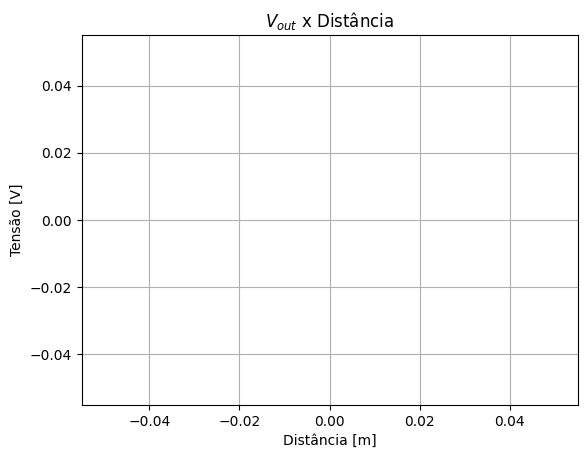

In [19]:
plt.plot(Distancias, TensoesMedidas,'co--')
plt.title("$V_{out}$ x Distância")
plt.grid(True)
plt.xlabel("Distância [m]")
plt.ylabel("Tensão [V]")
plt.show()

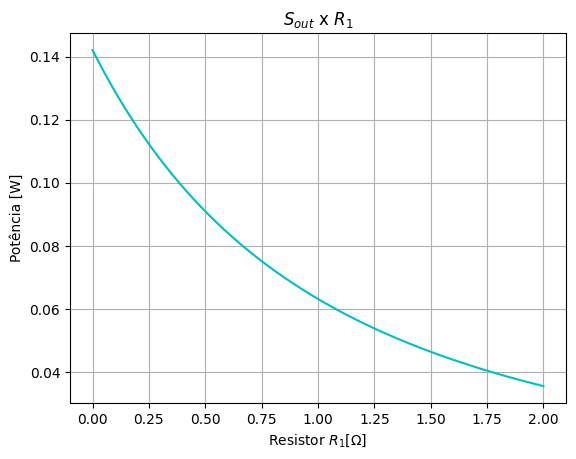

In [20]:
lisR1 = np.linspace(0,2,2000)
lisSout=[]

for R1 in lisR1:
    Trafo2.R1 = R1
    Trafo2.k = K_onde_maximo
    i1, i2 = CalcularTransformadorC2Paralelo(Trafo2, V1, Rcarga, f)

    Sin = V1*i1.conjugate()/2 #potência eficaz na entrada

    #tensão na saída
    XC2 = 1/(1j*w*Trafo2.C2) 
    Zparalelo = 1/(1/Rcarga+1/XC2)
    Vout = Zparalelo*i2
    Sout=(Vout*i2.conjugate()/2)
    
    lisSout.append(Sout.real)

%matplotlib inline
plt.plot(lisR1, lisSout,'c')
plt.title("$S_{out}$ x $R_1$")
plt.grid(True)
plt.xlabel("Resistor $R_1 [\Omega]$")
plt.ylabel("Potência [W]")
plt.show()

# Etapa III: RESULTADOS FINAIS E CONCLUSÃO

<img src="bobinasEcircuitos.jpg" height="426">

## Modelo
Potência de saída máxima: $0.74W$

Tensão máxima: $2.05V$

Valor de k quando a tensão é máxima: $0.89$

## Experimento
Potência de saída máxima: #preencher

Eficiência: #preencher

Tensão máxima medida: $5.16V$

Distância onde a tensão é máxima: #preencher

## Conclusão
Como poderíamos melhorar o nosso circuito?

- Capacitor de maior valor, para que a frequência de ressonância seja menor, e assim, a tensão de saída seja maior.
- Fio de maior espessura, para que a resistência seja menor, e assim, a potência de saída seja maior.
- Núcleo de ferro, para que a indutância seja maior, e assim, a potência de saída seja maior.
- Alimentação separada em cada protoboard, para que a potência de saída seja maior.
- Skin effect, para que a resistência seja menor, e assim, a potência de saída seja maior.
- Distribuição melhor de fios ou usar uma placa de circuito impresso, para que a resistência seja menor, e assim, a potência de saída seja maior.
- Enrolamento melhor das bobinas, para que a indutância seja maior, e assim, a potência de saída seja maior.
- Mais medições.